# SVGD for quantum tomography using PyMC

## This notebook is a tutorial of the report document from the project Crowdfund:
## [$Quantum](https://mirror.xyz/csferrie.eth/gUyt_o1KkZH-c3OHU85a8mfmLioNg4_uPHbtoAhcrR8)

In this notebook we are going to use PyMC in order to simulate the estimationn of random quantum states.


In [69]:
## import the libraries
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import time
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [70]:
## this cell is to have nice plots
########## 
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#############

In this notebook, a random quantum state is given by 4 random numbers coming from a normal distribution.  

Let $\vec{x}$ be a vector containing the 4 random numbers, 

$$\vec{x}=(x_0,x_1,x_2,x_3),$$  

and every $x_i$ is normal random variable. We want to get a random quantum state of the following way:

$$\tilde{\rho}= \frac{1}{||\tilde{\rho}||}\begin{bmatrix} x_0^2 & x_0(x_1-ix_2) \\ 
x_0 (x_1+ix_2)& x_1^2+x_2^2+x_3^2 \end{bmatrix}. $$

$\tilde{\rho}$ comes from

$$X= \begin{bmatrix} x_0 & 0 \\
x_1+ix_2 & x_3 \end{bmatrix},$$ 

using the Cholesky decomposition. 
Thus,

$$\tilde{\rho}=\frac{1}{||\tilde{\rho}||}X X^\dagger $$

This is the parameterization that we are going to use in order to estimate the quantum state. In other words, we are going to estimate each $x_i$ using SVGD method build in PyMC3

In [71]:
## We define the fucntion that will convert the vector x into a density matrix
## the input is the x0, x1,x2,x3 from the Cholesky decompostion
def vec2rho(x): 
    '''Generate a matrix using the Cholesky decomposition.  '''
    ##INPUT
    #x(list): list of 4 random numbers coming from a normal distribution
    #OUTPUT
    # rho(numpy matrix): normalized quantum state 
    
    d = int(np.sqrt(x.shape[0])) 
    X = 1j*np.zeros([d,d]) 
    # the first d-1 entries are the diagonal of X (the dth entry is fixed  by normalisation) 
    # the first d entries are the diagonal of X 
    np.fill_diagonal(X,x[:d]) 
    # indices of the upper triangle of d x d matrix 
    idu = np.triu_indices(d,1) 
    # take the next d (d-1)/2 entries and make them the real part of the upper triangle 
    X[idu] = x[d:d+int(d*(d-1)/2)] 
    # take the final d (d-1)/2 entrie
    # take the final d (d-1)/2 entries and make them the imaginary part of the upper triangle 
    X[idu] += -1j * x[-int(d*(d-1)/2):]  ## modified in order to get our tilde rho
    # now do the X^dag X thing 
    rho = X.T.conj() @ X 
    #rho = X@ X.T.conj() 
    return rho/np.trace(rho)

In [72]:
##testing function cell: this is cell test the function that we had created
x = np.array([1,2,3,4])
vec2rho(x) 

array([[0.03333333+0.j        , 0.1       -0.13333333j],
       [0.1       +0.13333333j, 0.96666667+0.j        ]])

## Fedelity is our metric

We need to know if we are estimating well the random quantum state. Thus, we are using fidelity. We are going to measure the fidelity of the random quatum state and the state given by SVGD. For denisity matrices, fedelity is given by:

$$ F(\rho,\sigma)=\biggr(Tr\sqrt{\sqrt{\rho} \sigma \sqrt{\rho} }\biggr)^2$$

For $2\times 2$ matrices, the square root of matrix is given by,

$$\sqrt\rho=\frac{1}{\tau} (\rho+det(\rho)^{0.5}\times I), $$
where $I$ is the identity matrix and 
$$\tau = (Tr(\rho)+2*det(\rho)^{0.5})^{0.5} $$ and $Tr(\rho)$ is the trace of $\rho$ and $det(\rho)$ is the determinant of $\rho$.

In [73]:
### fidelity of between mixed states 
# F(rho1, rho2) = (tr(sqrt( sqrt(rho1) rho2 sqrt(rho1))  )**2, 
#where
# sqrt A = 1/tau (A +det (A)**(0.5) * Identity) 
#and
# tau = (Tr A + 2 det(A)**(0.5) )**(0.5)

def sqrtmatrix(rho1):
    '''Generates the square root of a matrix 2x2'''
    #INPUT
    #rho1(numpy matrix 2x2 )
    #OUTPUT
    # (numpy matrix 2x2): the square root of rho1
    tracerho1 = np.trace(rho1)
    detrho1 = np.linalg.det(rho1)
    tau = (tracerho1+2.0*detrho1**(0.5))**0.5
    identity = np.array([[1.0,0.0],[0.0,1.0]])
    return 1/tau*(rho1+detrho1**(0.5)*identity)

def fidelity(rho1, rho2):
    '''Gives the fidelity of two density matrices'''
    #INPUT
    #rho1(numpy matrix 2x2 ): density matrix 
    #rho2(numpy matrix 2x2 ): density matrix
    #OUTPUT
    # (float): fidelity between rho1 and rho2
    sqrt1 = sqrtmatrix(rho1)
    aux = np.matmul(sqrt1,rho2)
    aux2 = np.matmul(aux,sqrt1)
    bigsqrt=sqrtmatrix(aux2)

    return ((np.trace(bigsqrt))**2).real

## Using SVGD to estimate a random quatum state

This is where PyMC will estimate $x_i$ with $i \in \lbrace0,1,2,3\rbrace$ using SVGD. 

In [74]:
## function that uses PyMC3  and estimates a random quantum state using SVGD and SMC 
def svgd_prestates(N=1000,z_observed=700,x_observed=200,y_observed=400,
                   svgd_num_part = 1000,svgd_lear_rate = 0.01,svgd_iter = 200):
  ''' Generate the posteior of the estimated xi with i\in{0,1,2,3} with svgd approximation and SMC '''
##INPUT
# N(int): number of total coin tosses. This is for the 3 axis: x,y,z
# z_observed(int): number of succes (heads) in N number of tosses of z coin
# x_observed(int): number of succes (heads) in N number of tosses of x coin
# y_observed(int): number of succes (heads) in N number of tosses of y coin
#svgd_num_part(int): number of particles for SVGD 
#svgd_lear_rate(float): learning rate of we are going to update the particles
#svgd_iter(int): total number of SVGD algorithm. This is max_iterations in the SVGD algorithm
##OUTPUT
#svgd_approx(pymc approximation): this is a pymc3 approximation result. This contains the modified priors
#
#sms(pymc approximation): this is a pymc3 sampling using SMC. This contains the modified priors 

  with pm.Model() as Binconstrain:
    #start with xi normal random variables
    x0 = pm.Normal("x0",mu = 0.0, sigma = 1.0)
    x1 = pm.Normal("x1",mu = 0.0, sigma = 1.0)
    x2 = pm.Normal("x2",mu = 0.0, sigma = 1.0)
    x3 = pm.Normal("x3",mu = 0.0, sigma = 1.0)

    #define the probabilities
    pz0 = (1+1/(x0**2+x1**2+x2**2+x3**2)*(x0**2-(x1**2+x2**2+x3**2)))/2
    px0 = (1+1/(x0**2+x1**2+x2**2+x3**2)*2*x0*x1)/2
    py0 = (1+1/(x0**2+x1**2+x2**2+x3**2)*2*x0*x2)/2
    
    #
    pz = pm.Deterministic('pz',pz0)
    px = pm.Deterministic('px',px0)
    py = pm.Deterministic('py',py0)

    zxy = pm.Binomial("z",n=N,p=pz,observed=z_observed)*pm.Binomial(
        "x",n=N,p=px,observed=x_observed)*pm.Binomial("y",n=N,p=py,observed=y_observed)

    ##SVGD approx
    svgd_approx = pm.fit(svgd_iter,method="svgd",inf_kwargs=dict(
        n_particles=svgd_num_part),obj_optimizer = pm.adam(learning_rate=svgd_lear_rate),progressbar=False)
    
    #comparison with SMS
    sms = pm.sample_smc(2000,parallel=True,cores=4)
    #az_trace = az.from_pymc3(sms)
    
    
    return svgd_approx, sms


## From SVGD or SMC to a quatum state 

The following fucntions will transform the output of SVGD and SMC into quantum density matrices.

In [75]:
## from svgd_fit to a density matrix
def svgd_rho_mean(svgd_state, n_samples = 2000):
    '''This function will generate an estimated quantum state using SVGD'''
    ### INPUT
    #svgd_state(PyMC 3 approximation): appoximation of a variational posterior given by SVGD
    #n_samples(int): Draw samples from variational posterior.
    ##OUTPUT
    # rho(numpy matrix): density matrix or quantum state using SVGD 
    #
    fullsamples = svgd_state.sample(n_samples)
    x0_matrix = fullsamples['x0'] # from the posterior we take the estimated prior ['x0']
    x1_matrix = fullsamples['x1'] # from the posterior we take the estimated prior ['x1']
    x2_matrix = fullsamples['x2'] # from the posterior we take the estimated prior ['x2']
    x3_matrix = fullsamples['x3'] # from the posterior we take the estimated prior ['x3']
    rho = 1j * np.zeros([2,2])
    for i in range(n_samples):
        vec = np.array([x0_matrix[i],x3_matrix[i],x1_matrix[i],x2_matrix[i]])
        rho += vec2rho(vec)
    rho = rho/n_samples
    return rho 

### from sms to a density matrix

def sms_rho(sms_sample, n_samples=2000):
    '''This function will generate an estimated quantum state using SMC'''
    ### INPUT
    #sms_sample(PYMC approximation): appoximation of a variational posterior given by SVGD
    #n_samples(int): Draw samples from variational posterior.
    ##OUTPUT
    # rho(numpy matrix): density matrix or quantum state using SMC 
    
    x0_matrix = sms_sample['x0']
    x1_matrix = sms_sample['x1']
    x2_matrix = sms_sample['x2']
    x3_matrix = sms_sample['x3']
    rho = 1j * np.zeros([2,2])
    for i in range(n_samples):
        vec = np.array([x0_matrix[i],x3_matrix[i],x1_matrix[i],x2_matrix[i]])
        rho += vec2rho(vec)
    rho = rho/n_samples
    return rho

## Generate a random state

In the following lines, we are going to estimate random quantum states and plot the results.

In [76]:
# generate the 4 random numbers
x = np.random.randn(4)
print("the 4 random numbers are:")
print(x)
print(" ")
print("The random density matrix is :")
print(vec2rho(np.array([x[0],x[3],x[1],x[2]])))

the 4 random numbers are:
[-0.93699007 -0.98076478 -1.77350299  0.89323058]
 
The random density matrix is :
[[0.15181511+0.j         0.15890768-0.28735049j]
 [0.15890768+0.28735049j 0.84818489+0.j        ]]


In [77]:
## measure the density matrix in the 3 axis: x,y,z
def get_probs(x):
    '''Given the 4 random numbers, we get the probabilities of the density matrix '''
    pz = (1+1/(x[0]**2+x[1]**2+x[2]**2+x[3]**2)*(x[0]**2-(x[1]**2+x[2]**2+x[3]**2)))/2
    px = (1+1/(x[0]**2+x[1]**2+x[2]**2+x[3]**2)*2*x[0]*x[1])/2
    py = (1+1/(x[0]**2+x[1]**2+x[2]**2+x[3]**2)*2*x[0]*x[2])/2
    return np.array([px,py,pz])

print("Probabilities of measuring the random density matrix in the x, y and z axis:")
get_probs(x)

Probabilities of measuring the random density matrix in the x, y and z axis:


array([0.65890768, 0.78735049, 0.15181511])

In [78]:
## Using the probabilities to get the number of successes 
def sim_experiment(x, N = 1000):
    '''Get the number of successes of 3 binomial distributions using the 4 random numbers'''
    p = get_probs(x)
    nx = np.random.binomial(N,p[0])
    ny = np.random.binomial(N,p[1])
    nz = np.random.binomial(N,p[2])
    return np.array([nx,ny,nz])

n = sim_experiment(x,N = 1000)
print("Number of successes in "+str(1000)+" toses is")
print(n)

Number of successes in 1000 toses is
[637 806 149]


## The whole simulation process

In the following line, we are simulating the estimation process. We are using only 2 number of simulations because if we use grater numbers like 50 or 100 it will take more time the simulation. The reader is free to change 
n_sim

in order to generate more data and get better results. 

We want to explore:
- how SVGD performs with 10, 100 and 1000 number of measurements $N$ (or total of tosses) and
- how SVGD performs with 10, 100, 1000 number of particles
- how SVGD performs againts SMC

In [ ]:
## running the simulations
start_time = time.time()

n_sim = 2
N = np.array([10,100,1000])  ## number of measurements 
#N = np.array([100,1000])  ## number of measurements 

particle_num = np.array([10,100,1000]) ## number of particles in SVGD

statistics = np.zeros([n_sim,N.shape[0],particle_num.shape[0]])
statistics_sms = np.zeros([n_sim,N.shape[0],particle_num.shape[0]])

for idP in range(particle_num.shape[0]):
    for idN in range(N.shape[0]):
        for idx in range(n_sim):
            true_state = np.random.randn(4)
            data = sim_experiment(true_state, N = N[idN])
            svgd, sms_sample = svgd_prestates(N[idN],z_observed=data[2],x_observed=data[0],y_observed=data[1], svgd_num_part = particle_num[idP], svgd_lear_rate = 0.01, svgd_iter = 400)
            svgd_state = svgd_rho_mean(svgd)
            sms_state = sms_rho(sms_sample)
            
            #print("svgd_state:",svgd_state)
            #print("sms_state",sms_state)
            #print("true_state:",vec2rho(np.array([true_state[0],true_state[3],true_state[1],true_state[2]]) ) )
            statistics[idx,idN,idP] = fidelity(vec2rho(np.array([true_state[0],true_state[3],true_state[1],true_state[2]])),svgd_state)
            statistics_sms[idx,idN,idP] = fidelity(vec2rho(np.array([true_state[0],true_state[3],true_state[1],true_state[2]])),sms_state)

print("--- %s seconds ---" % (time.time() - start_time))

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.347
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.477
Stage:   1 Beta: 1.000


## Results

Print all the simulations:


In [ ]:
print("svgd-fidelity:",statistics)
print("")
print("sms-fidelity:",statistics_sms)

## Average of fidelilty

In the case of SVGD, we get the mean with respect of the number of simulations. Deu to the fact that we are interested in the performance of SVGD with respect to particles and measurements. 

In the case of SMC, we get the mean with respect of the number of simulations and with respect of particles. SMC does not work with particles

In [ ]:
ave_statistics = np.mean(statistics, axis = 0)
ave_statistics_sms=np.mean(np.mean(statistics_sms, axis = 0),axis=1)

print("svgd:",ave_statistics)
print("")
print("ave_sms",ave_statistics_sms)


## Plots

In [ ]:
plt.rcParams["figure.figsize"] = 8, 5
plt.plot(N, ave_statistics[:,0], label = str(particle_num[0])+" particles-SVGD")
plt.plot(N, ave_statistics[:,1], label = str(particle_num[1])+" particles-SVGD")
plt.plot(N, ave_statistics[:,2], label = str(particle_num[2])+" particles-SVGD")

plt.plot(N, ave_statistics_sms, label = "SMC")
#plt.plot(N, ave_statistics_sms[:,1], label = "SMC and SVGD uses "+str(particle_num[1])+" part.")
#plt.plot(N, ave_statistics_sms[:,2], label = "SMC and SVGD uses "+str(particle_num[2])+" part.")
plt.legend(fontsize=10,loc=0)
plt.ylabel("Average Fidelity",fontsize=16)
plt.xlabel("Number of measurements",fontsize=16)
plt.title("SVGD using adam vs SMC: Average Fidelity vs $N$",fontsize=16)
plt.legend(fontsize=13)
plt.grid()
plt.savefig('svgd-adam-measurements.png')

In [ ]:
plt.plot(particle_num, ave_statistics[0,:], label = str(N[0])+" measurements-SVGD")
plt.plot(particle_num, ave_statistics[1,:], label = str(N[1])+" measurements-SVGD")
plt.plot(particle_num, ave_statistics[2,:], label = str(N[2])+" measurements-SVGD")

#plt.plot(particle_num, ave_statistics_sms[0,:], label = str(N[0])+" measurements-SMC")
#plt.plot(particle_num, ave_statistics_sms[1,:], label = str(N[1])+" measurements-SMC")
#plt.plot(particle_num, ave_statistics_sms[2,:], label = str(N[2])+" measurements-SMC")
plt.legend(fontsize=10,loc=0)
plt.ylabel("Average Fidelity",fontsize=16)
plt.xlabel("Number of particles",fontsize=16)
plt.title("Aver. fidelity vs num. particles :using adam ",fontsize=16)
plt.legend(fontsize=11)
plt.grid()
plt.savefig('svgd-adam-particles.png')

## Extra plots

The following plots are the modified priors of $x_0, x_1, x_2, x_3$

In [ ]:
n_samples = 1000
fullsamples = svgd.sample(n_samples)
x0_matrix = fullsamples['x0']
x1_matrix = fullsamples['x1']
x2_matrix = fullsamples['x2']
x3_matrix = fullsamples['x3']
ax =sns.kdeplot(x0_matrix, label="SVGD")

In [ ]:
bx =sns.kdeplot(x1_matrix, label="SVGD")

In [ ]:
cx =sns.kdeplot(x2_matrix, label="SVGD")

In [ ]:
dx =sns.kdeplot(x3_matrix, label="SVGD")

## More simulations

### Be careful:
The following simulation is with n_sim=70. This will take 30676.97034263611 seconds, be careful with your time.

In [28]:
## running the simulations
start_time = time.time()

n_sim = 70
N = np.array([10,100,1000])  ## number of measurements 

particle_num = np.array([10,100,1000]) ## number of particles in SVGD

statistics = np.zeros([n_sim,N.shape[0],particle_num.shape[0]])
statistics_sms = np.zeros([n_sim,N.shape[0],particle_num.shape[0]])

for idP in range(particle_num.shape[0]):

    for idN in range(N.shape[0]):

        for idx in range(n_sim):
            true_state = np.random.randn(4)
            data = sim_experiment(true_state, N = N[idN])
            svgd, sms_sample = svgd_prestates(N[idN],z_observed=data[2],x_observed=data[0],y_observed=data[1], svgd_num_part = particle_num[idP], svgd_lear_rate = 0.01, svgd_iter = 400)
            svgd_state = svgd_rho_mean(svgd)
            sms_state = sms_rho(sms_sample)
            #print("svgd_state:",svgd_state)
            #print("sms_state",sms_state)
            #print("true_state:",vec2rho(np.array([true_state[0],true_state[3],true_state[1],true_state[2]]) ) )
            statistics[idx,idN,idP] = fidelity(vec2rho(np.array([true_state[0],true_state[3],true_state[1],true_state[2]])),svgd_state)
            statistics_sms[idx,idN,idP] = fidelity(vec2rho(np.array([true_state[0],true_state[3],true_state[1],true_state[2]])),sms_state)

            
print("--- %s seconds ---" % (time.time() - start_time))

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.176
Stage:   1 Beta: 0.517
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.213
Stage:   1 Beta: 0.613
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.539
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.231
Stage:   1 Beta: 0.740
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.458
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.345
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.167
Stage:   1 Beta: 0.480
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.242
Stage:   1 Beta: 0.731
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Be

Stage:   1 Beta: 0.170
Stage:   2 Beta: 0.449
Stage:   3 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.021
Stage:   1 Beta: 0.068
Stage:   2 Beta: 0.210
Stage:   3 Beta: 0.565
Stage:   4 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.034
Stage:   1 Beta: 0.100
Stage:   2 Beta: 0.235
Stage:   3 Beta: 0.586
Stage:   4 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.040
Stage:   1 Beta: 0.139
Stage:   2 Beta: 0.383
Stage:   3 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.012
Stage:   1 Beta: 0.036
Stage:   2 Beta: 0.097
Stage:   3 Beta: 0.253
Stage:   4 Beta: 0.662
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.021
Stage:   1 Beta: 0.065
Stage:   2 Beta: 0.191
Stage:   3 Beta: 0.589
Stage:   4 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.0

Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.024
Stage:   1 Beta: 0.077
Stage:   2 Beta: 0.217
Stage:   3 Beta: 0.631
Stage:   4 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.029
Stage:   1 Beta: 0.095
Stage:   2 Beta: 0.278
Stage:   3 Beta: 0.723
Stage:   4 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.039
Stage:   1 Beta: 0.309
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.039
Stage:   1 Beta: 0.133
Stage:   2 Beta: 0.393
Stage:   3 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.016
Stage:   1 Beta: 0.053
Stage:   2 Beta: 0.145
Stage:   3 Beta: 0.368
Stage:   4 Beta: 0.921
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.011
Stage:   1 Beta: 0.035
Stage:   2 Beta: 0.091
Stage:   3 Beta: 0.251
Stage:   4 Beta: 0.719
Stage:   5 Beta: 1.000
Initializing SMC sampler.

Stage:   4 Beta: 0.312
Stage:   5 Beta: 0.910
Stage:   6 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.010
Stage:   3 Beta: 0.028
Stage:   4 Beta: 0.079
Stage:   5 Beta: 0.207
Stage:   6 Beta: 0.502
Stage:   7 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.011
Stage:   3 Beta: 0.031
Stage:   4 Beta: 0.085
Stage:   5 Beta: 0.236
Stage:   6 Beta: 0.655
Stage:   7 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.004
Stage:   1 Beta: 0.013
Stage:   2 Beta: 0.037
Stage:   3 Beta: 0.095
Stage:   4 Beta: 0.229
Stage:   5 Beta: 0.579
Stage:   6 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.005
Stage:   1 Beta: 0.023
Stage:   2 Beta: 0.070
Stage:   3 Beta: 0.208
Stage:   4 Beta: 0.624
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 4 c

Stage:   5 Beta: 0.639
Stage:   6 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.002
Stage:   1 Beta: 0.005
Stage:   2 Beta: 0.015
Stage:   3 Beta: 0.038
Stage:   4 Beta: 0.095
Stage:   5 Beta: 0.249
Stage:   6 Beta: 0.623
Stage:   7 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.009
Stage:   2 Beta: 0.026
Stage:   3 Beta: 0.076
Stage:   4 Beta: 0.226
Stage:   5 Beta: 0.708
Stage:   6 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.012
Stage:   3 Beta: 0.033
Stage:   4 Beta: 0.099
Stage:   5 Beta: 0.298
Stage:   6 Beta: 0.875
Stage:   7 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.009
Stage:   2 Beta: 0.025
Stage:   3 Beta: 0.074
Stage:   4 Beta: 0.214
Stage:   5 Beta: 0.626
Stage:   6 Beta: 1.000
Initializing SMC sampler...
Sampling 4 c

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.405
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.405
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.224
Stage:   1 Beta: 0.640
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.405
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.266
Stage:   1 Beta: 0.855
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.128
Stage:   1 Beta: 0.382
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.390
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.107
Stage:   1 Beta: 0.325
Stage:   2 Beta: 0.901
Stage:   3 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Be

Stage:   1 Beta: 0.275
Stage:   2 Beta: 0.737
Stage:   3 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.026
Stage:   1 Beta: 0.081
Stage:   2 Beta: 0.231
Stage:   3 Beta: 0.674
Stage:   4 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.043
Stage:   1 Beta: 0.230
Stage:   2 Beta: 0.665
Stage:   3 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.041
Stage:   1 Beta: 0.347
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.049
Stage:   1 Beta: 0.189
Stage:   2 Beta: 0.570
Stage:   3 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.020
Stage:   1 Beta: 0.064
Stage:   2 Beta: 0.172
Stage:   3 Beta: 0.415
Stage:   4 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.024
Stage:   1 Beta: 0.067
Stage:   2 Beta: 0.159
Stage:   3 Beta: 0.410
Stage:   4 Beta: 1.0

Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.009
Stage:   2 Beta: 0.028
Stage:   3 Beta: 0.082
Stage:   4 Beta: 0.199
Stage:   5 Beta: 0.481
Stage:   6 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.004
Stage:   1 Beta: 0.012
Stage:   2 Beta: 0.033
Stage:   3 Beta: 0.095
Stage:   4 Beta: 0.282
Stage:   5 Beta: 0.851
Stage:   6 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.004
Stage:   1 Beta: 0.035
Stage:   2 Beta: 0.141
Stage:   3 Beta: 0.408
Stage:   4 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.012
Stage:   3 Beta: 0.033
Stage:   4 Beta: 0.094
Stage:   5 Beta: 0.259
Stage:   6 Beta: 0.698
Stage:   7 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.003
Stage:   2 Beta: 0.009
Stage:   3 Beta: 0.027
Stage:   4 Beta: 0.076
Stage:   5 B

Stage:   0 Beta: 0.002
Stage:   1 Beta: 0.006
Stage:   2 Beta: 0.017
Stage:   3 Beta: 0.042
Stage:   4 Beta: 0.108
Stage:   5 Beta: 0.274
Stage:   6 Beta: 0.679
Stage:   7 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.005
Stage:   1 Beta: 0.025
Stage:   2 Beta: 0.076
Stage:   3 Beta: 0.213
Stage:   4 Beta: 0.609
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.009
Stage:   2 Beta: 0.027
Stage:   3 Beta: 0.081
Stage:   4 Beta: 0.249
Stage:   5 Beta: 0.714
Stage:   6 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.010
Stage:   3 Beta: 0.028
Stage:   4 Beta: 0.080
Stage:   5 Beta: 0.217
Stage:   6 Beta: 0.613
Stage:   7 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.005
Stage:   1 Beta: 0.030
Stage:   2 Beta: 0.087
Stage:   3 Beta: 0.209
Stage:   4 Beta: 

Stage:   0 Beta: 0.381
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.372
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.304
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.239
Stage:   1 Beta: 0.721
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.326
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.377
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.213
Stage:   1 Beta: 0.618
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.410
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.183
Stage:   1 Beta: 0.559
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Be

Stage:   1 Beta: 0.047
Stage:   2 Beta: 0.130
Stage:   3 Beta: 0.346
Stage:   4 Beta: 0.889
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.041
Stage:   1 Beta: 0.352
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.047
Stage:   1 Beta: 0.208
Stage:   2 Beta: 0.632
Stage:   3 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.036
Stage:   1 Beta: 0.123
Stage:   2 Beta: 0.360
Stage:   3 Beta: 0.914
Stage:   4 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.016
Stage:   1 Beta: 0.052
Stage:   2 Beta: 0.142
Stage:   3 Beta: 0.398
Stage:   4 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.046
Stage:   1 Beta: 0.196
Stage:   2 Beta: 0.558
Stage:   3 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.040
Stage:   1 Beta: 0.144
Stage:   2 Beta: 0.4

Stage:   0 Beta: 0.002
Stage:   1 Beta: 0.007
Stage:   2 Beta: 0.021
Stage:   3 Beta: 0.059
Stage:   4 Beta: 0.171
Stage:   5 Beta: 0.498
Stage:   6 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.005
Stage:   1 Beta: 0.018
Stage:   2 Beta: 0.054
Stage:   3 Beta: 0.153
Stage:   4 Beta: 0.372
Stage:   5 Beta: 0.917
Stage:   6 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.004
Stage:   1 Beta: 0.034
Stage:   2 Beta: 0.119
Stage:   3 Beta: 0.345
Stage:   4 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.004
Stage:   2 Beta: 0.010
Stage:   3 Beta: 0.028
Stage:   4 Beta: 0.080
Stage:   5 Beta: 0.219
Stage:   6 Beta: 0.631
Stage:   7 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.004
Stage:   1 Beta: 0.011
Stage:   2 Beta: 0.028
Stage:   3 Beta: 0.070
Stage:   4 Beta: 0.173
Stage:   5 Beta: 0.427
Stage:   6 Beta: 

Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.005
Stage:   2 Beta: 0.012
Stage:   3 Beta: 0.029
Stage:   4 Beta: 0.072
Stage:   5 Beta: 0.189
Stage:   6 Beta: 0.512
Stage:   7 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.004
Stage:   1 Beta: 0.033
Stage:   2 Beta: 0.265
Stage:   3 Beta: 1.000
Stage:   4 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.004
Stage:   1 Beta: 0.013
Stage:   2 Beta: 0.037
Stage:   3 Beta: 0.110
Stage:   4 Beta: 0.323
Stage:   5 Beta: 0.860
Stage:   6 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.004
Stage:   1 Beta: 0.022
Stage:   2 Beta: 0.065
Stage:   3 Beta: 0.179
Stage:   4 Beta: 0.492
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.002
Stage:   1 Beta: 0.005
Stage:   2 Beta: 0.014
Stage:   3 Beta: 0.042
Stage:   4 Beta: 0.126
Stage:   5 Beta: 0.343
Stage:   6 B

--- 30676.97034263611 seconds ---


In [61]:
print("svgd-fidliety:",statistics)
print("")
print("sms-fidelity:",statistics_sms)

ave_statistics = np.mean(statistics, axis = 0)
ave_statistics_sms=np.mean(np.mean(statistics_sms, axis = 0),axis=1)
print("svgd:",ave_statistics)
print("")
print("ave_sms",ave_statistics_sms)
#ave_statistics[0,:]

svgd-fidliety: [[[0.91335548 0.94771287 0.90030946]
  [0.99048945 0.99545983 0.98978528]
  [0.96866035 0.9879611  0.98840236]]

 [[0.87190897 0.91917359 0.9278272 ]
  [0.9942537  0.99024017 0.99416084]
  [0.98447624 0.99967302 0.99351064]]]

sms-fidelity: [[[0.9456665  0.95037928 0.89806389]
  [0.99686345 0.99655254 0.99462895]
  [0.99900668 0.99946196 0.9991141 ]]

 [[0.86711117 0.92296207 0.92520817]
  [0.99427463 0.97595666 0.99731269]
  [0.99579379 0.99962931 0.99811669]]]
svgd: [[0.89263222 0.93344323 0.91406833]
 [0.99237157 0.99285    0.99197306]
 [0.9765683  0.99381706 0.9909565 ]]

ave_sms [0.91823185 0.99259815 0.99852042]


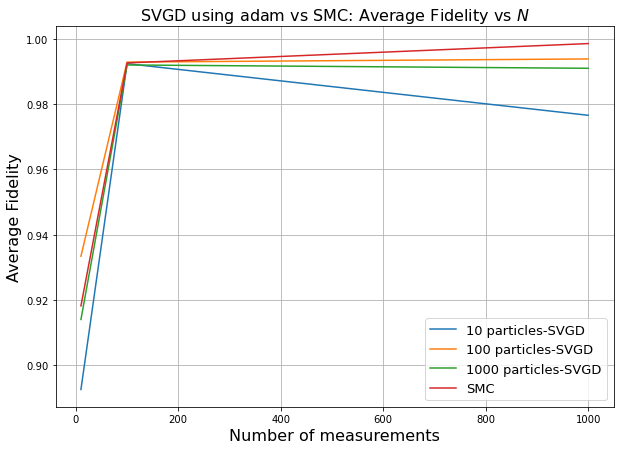

In [48]:
plt.rcParams["figure.figsize"] = 10, 7
plt.plot(N, ave_statistics[:,0], label = str(particle_num[0])+" particles-SVGD")
plt.plot(N, ave_statistics[:,1], label = str(particle_num[1])+" particles-SVGD")
plt.plot(N, ave_statistics[:,2], label = str(particle_num[2])+" particles-SVGD")

plt.plot(N, ave_statistics_sms, label = "SMC")

plt.legend(fontsize=10,loc=0)
plt.ylabel("Average Fidelity",fontsize=16)
plt.xlabel("Number of measurements",fontsize=16)
plt.title("SVGD using adam vs SMC: Average Fidelity vs $N$",fontsize=16)
plt.legend(fontsize=13)
plt.grid()
plt.savefig('svgd-adam-measurements.png')

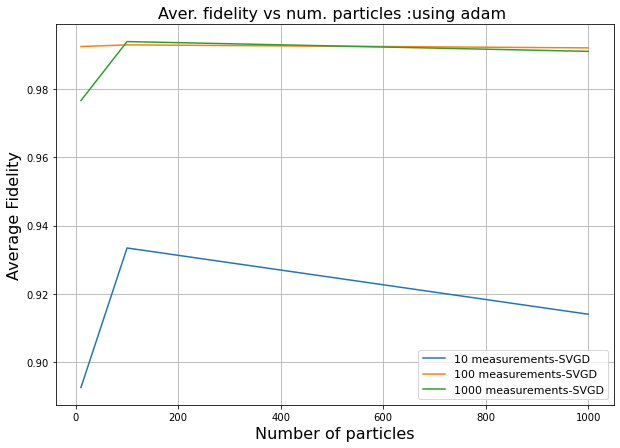

In [50]:
plt.plot(particle_num, ave_statistics[0,:], label = str(N[0])+" measurements-SVGD")
plt.plot(particle_num, ave_statistics[1,:], label = str(N[1])+" measurements-SVGD")
plt.plot(particle_num, ave_statistics[2,:], label = str(N[2])+" measurements-SVGD")

plt.legend(fontsize=10,loc=0)
plt.ylabel("Average Fidelity",fontsize=16)
plt.xlabel("Number of particles",fontsize=16)
plt.title("Aver. fidelity vs num. particles :using adam ",fontsize=16)
plt.legend(fontsize=11)
plt.grid()
plt.savefig('svgd-adam-particles.png')

In [67]:

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2
